In [1]:
import torch
import torchtext

# The first time you run this will download a ~823MB file
glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=50)   # embedding size = 50

.vector_cache\glove.6B.zip: 862MB [26:32, 541kB/s]                                                                     
100%|██████████████████████████████████████████████████████████████████████▉| 399999/400000 [00:19<00:00, 20599.83it/s]


In [25]:
#All Imports
import torchtext
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [26]:
def read_files():    
    f = open("happy_lyrics_scraped.txt", "r")
    raw_happy_file = f.read()
    f = open("sad_lyrics_scraped.txt", "r")
    raw_sad_file = f.read()
    return raw_happy_file, raw_sad_file

def process_raw(raw_happy_file, raw_sad_file):
    #split song titles
    raw_happy_list = raw_happy_file.split("###")[1:]
    raw_sad_list = raw_sad_file.split("###")[1:]
    
    #just get the lyrics
    happy_lyrics_list = [raw_happy_list[i*2+1] for i in range(int(len(raw_happy_list)/2))]
    sad_lyrics_list = [raw_sad_list[i*2+1] for i in range(int(len(raw_sad_list)/2))]
    target_list = [1 for i in range(len(happy_lyrics_list))] + [0 for i in range(len(sad_lyrics_list))]
    lyrics_list = happy_lyrics_list + sad_lyrics_list
    for i in range(len(lyrics_list)):
        lyrics_list[i] = lyrics_list[i].lower()
        lyrics_list[i] = lyrics_list[i].replace('\n',' ').strip(' ')
    return target_list, lyrics_list



In [27]:
#Read and Preliminary Processing
raw_happy_file, raw_side_file= read_files()
target_list, lyrics_list=process_raw(raw_happy_file, raw_side_file)

In [28]:
#Create a dataframe from processed data
data_tuples=list(zip(lyrics_list,target_list))
df=pd.DataFrame(data_tuples, columns=['Lyrics','Target'])

In [29]:
#Set Fields

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index

label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True)

In [30]:
#Process the lyrics using field
preprocess_lyrics=df['Lyrics'].apply(lambda x:text_field.preprocess(x))
print(preprocess_lyrics)

0      [i, thought, love, was, only, true, in, fairy,...
1      [you, know, i, like, my, chicken, fried, and, ...
2      [baby, why, don't, we, just, turn, that, tv, o...
3      [i, got, rice, cookin', in, the, microwave, go...
4      [jeremiah, was, a, bull, frog, was, a, good, f...
                             ...                        
106    [there, goes, my, heart, beating, cause, you, ...
107    [notice, me, take, my, hand, why, are, we, str...
108    [hear, that, lonesome, whippoorwill, he, sound...
109    [i, took, the, supermarket, flowers, from, the...
110    [all, around, me, are, familiar, faces, worn, ...
Name: Lyrics, Length: 111, dtype: object


In [62]:
#Build Vocab with preprocessed lyrics
#problem here...
text_field.build_vocab(preprocess_lyrics, vectors="glove.6B.100d")
vocab=text_field.vocab

100%|██████████████████████████████████████████████████████████████████████▉| 399999/400000 [00:27<00:00, 14423.81it/s]


In [75]:
vocab.vectors.shape
print(len(vocab))

3221


In [63]:
#Want to convert dataframe to dataset
from torchtext.data import Dataset, Example

class DataFrameDataset(Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                Example.fromlist(list(r), fields) 
                for i, r in df.iterrows()
            ], 
            fields
        )

In [64]:
#Create a dataset from dataframe and split it in train, valid, test
fields = [('Lyrics', text_field),('Target', label_field)]
working_dataset= DataFrameDataset(df,fields)
train, valid, test= working_dataset.split([0.6,0.2,0.2])
print("length of train, val, test is:", len(train), len(valid), len(test))

length of train, val, test is: 67 22 22


In [65]:
#RNN Set Up
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.name="PleaseWork"
        self.emb = nn.Embedding(len(vocab), num_input)
        self.emb.weight.data.copy_(vocab.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
     
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out=self.fc(out[:, -1, :])
        return out


In [66]:
#Train Network
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5,batch_size=32):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for batch in train:
            if (0 not in batch.Lyrics[1]):
                optimizer.zero_grad()
                pred = model(batch.Lyrics[0])

                loss = criterion(pred, batch.Target)
                loss.backward()
                optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    #Saving
    model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), model_path)

    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), losses)
    np.savetxt("{}_val_acc.csv".format(model_path), valid_acc)

In [67]:
#Get Accuracy
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above   """

    correct, total = 0, 0
    for batch in data:
        if 0 not in batch.Lyrics[1]:
            output = model(batch.Lyrics[0])
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(batch.Target.view_as(pred)).sum().item()
            total += len(batch.Target)

    return correct / total

In [68]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [69]:
#Set the iterators
batch_size=1
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=batch_size)
valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=batch_size)
test_iter =torchtext.data.BucketIterator(test, batch_size=batch_size)

Epoch 1; Loss 0.818499; Train Acc 0.537313; Val Acc 0.545455
Epoch 2; Loss 0.978039; Train Acc 0.567164; Val Acc 0.545455
Epoch 3; Loss 0.557292; Train Acc 0.611940; Val Acc 0.409091
Epoch 4; Loss 0.543611; Train Acc 0.701493; Val Acc 0.409091
Epoch 5; Loss 0.769429; Train Acc 0.761194; Val Acc 0.409091
Epoch 6; Loss 0.671042; Train Acc 0.805970; Val Acc 0.409091
Epoch 7; Loss 0.649105; Train Acc 0.805970; Val Acc 0.500000
Epoch 8; Loss 0.588604; Train Acc 0.835821; Val Acc 0.454545
Epoch 9; Loss 0.601551; Train Acc 0.850746; Val Acc 0.454545
Epoch 10; Loss 0.252649; Train Acc 0.820896; Val Acc 0.454545
Epoch 11; Loss 0.489028; Train Acc 0.880597; Val Acc 0.454545
Epoch 12; Loss 0.225809; Train Acc 0.880597; Val Acc 0.454545
Epoch 13; Loss 0.261308; Train Acc 0.910448; Val Acc 0.454545
Epoch 14; Loss 0.558002; Train Acc 0.910448; Val Acc 0.454545
Epoch 15; Loss 0.497868; Train Acc 0.925373; Val Acc 0.500000
Epoch 16; Loss 0.324416; Train Acc 0.925373; Val Acc 0.454545
Epoch 17; Loss 0.

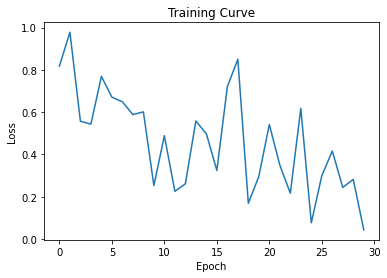

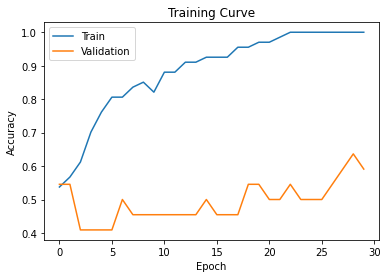

In [71]:
num_input=100

model = RNN(num_input, 50, 2)
train_rnn_network(model, train_iter, valid_iter, num_epochs=30, learning_rate=1e-4,batch_size=batch_size)